<a href="https://colab.research.google.com/github/mohitDhami87/YouTube_Shorts_Performance_Prediction_Case_Study/blob/main/YouTube_Shorts_Performance_Prediction_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YouTube Shorts Performance Prediction Case Study**


---



The core challenge of this case study is to leverage Supervised Machine Learning to predict
the potential performance (specifically, the Engagement Rate tertile: Low, Medium, or High) of a
YouTube Short based on its intrinsic features (title, duration, category) and its publishing
behavior (upload hour). The final goal is to develop a reliable predictive model and deliver
actionable content strategy recommendations to maximize viral potential and channel
growth.


---



In [ ]:
# Gdrive dataset link
# https://drive.google.com/file/d/1e4_e0JfuOdBPQodG_jaOvCJnEYMK4YNs/view?usp=drive_link

In [2]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Loading dataset

dataset_url_path = 'https://drive.google.com/uc?export=download&id=1e4_e0JfuOdBPQodG_jaOvCJnEYMK4YNs'
df = pd.read_csv(dataset_url_path)
df.head()

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        300 non-null    object
 1   title           300 non-null    object
 2   duration_sec    300 non-null    int64 
 3   hashtags_count  300 non-null    int64 
 4   views           300 non-null    int64 
 5   likes           300 non-null    int64 
 6   comments        300 non-null    int64 
 7   shares          300 non-null    int64 
 8   upload_hour     300 non-null    int64 
 9   category        300 non-null    object
dtypes: int64(7), object(3)
memory usage: 23.6+ KB


In [5]:
df.describe()

,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,31.730000,4.343333,245058.166667,23063.126667,2638.296667,999.576667,11.543333
std,16.042912,2.956562,141338.982093,14597.458220,1416.827287,564.410105,6.814414
min,5.000000,0.000000,1404.000000,109.000000,40.000000,2.000000,0.000000
25%,18.000000,2.000000,129620.500000,10342.000000,1445.750000,516.250000,6.000000
50%,32.000000,4.000000,255962.000000,21779.500000,2863.500000,988.000000,12.000000
75%,45.000000,7.000000,356805.000000,36706.500000,3761.000000,1463.750000,17.000000
max,59.000000,9.000000,499401.000000,49923.000000,4971.000000,1998.000000,23.000000


In [10]:
df.isnull().any()

,0
video_id,False
title,False
duration_sec,False
hashtags_count,False
views,False
likes,False
comments,False
shares,False
upload_hour,False
category,False


In [11]:
# Checking shape of dataframe
print(f'Number of rows in training dataset: {df.shape[0]}')
print(f'Number of columns in training dataset: {df.shape[1]}')

Number of rows in training dataset: 300
Number of columns in training dataset: 10


In [12]:
categorical_cols = df.select_dtypes(include='object').columns
categorical_cols

Index(['video_id', 'title', 'category'], dtype='object')

In [13]:
def classify_columns(data):
    # Initialize lists for categorical and numerical columns
    cat_col = []
    num_col = []

    # Iterate through columns in the DataFrame
    for column in data.columns:
        # Count the number of unique values in the column
        unique_values = data[column].nunique()

        # If there are fewer than 3 unique values, consider it a categorical column
        if unique_values < 3:
            cat_col.append(column)
        # Otherwise, consider it a numerical column
        else:
            num_col.append(column)

    # Return the lists of categorical and numerical columns
    return cat_col, num_col


In [14]:
cat_col, num_col = classify_columns(df)
print(f'Categorical columns in training dataset: {cat_col}')
print(f'Numerical columns in training dataset: {num_col}')

Categorical columns in training dataset: []
Numerical columns in training dataset: ['video_id', 'title', 'duration_sec', 'hashtags_count', 'views', 'likes', 'comments', 'shares', 'upload_hour', 'category']


In [15]:
# Perform correlation analysis to identify relationships between features
correlation = df.corr(numeric_only=True)
correlation["likes"].sort_values(ascending=False)

,likes
likes,1.000000
views,0.035115
hashtags_count,0.011884
upload_hour,-0.014855
comments,-0.034672
shares,-0.037390
duration_sec,-0.052211


In [16]:
likes_count = df['likes'].value_counts()
likes_count

,count
likes,
6471,2
27634,1
19316,1
43436,1
1442,1
...,...
10367,1
45640,1
38618,1


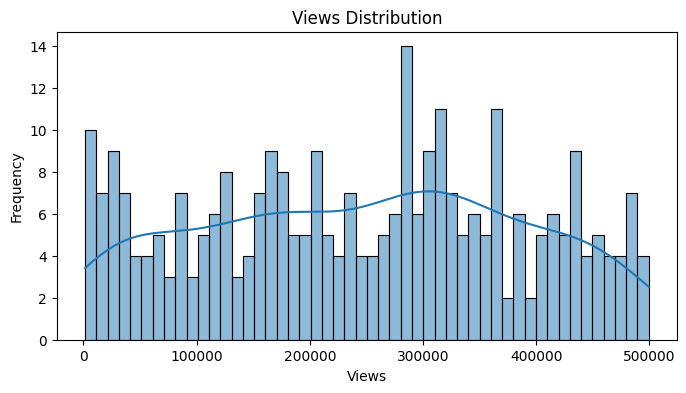

In [17]:
plt.figure(figsize=(8,4))
sns.histplot(df['views'], bins=50, kde=True)
plt.title("Views Distribution")
plt.xlabel("Views")
plt.ylabel("Frequency")
plt.show()

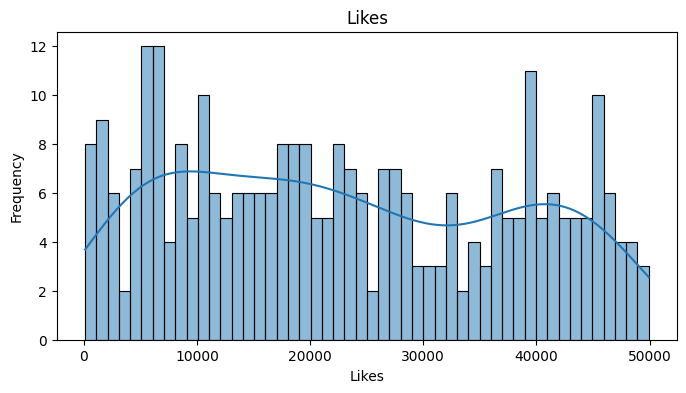

In [19]:
plt.figure(figsize=(8,4))
sns.histplot(df['likes'], bins=50, kde=True)
plt.title("Likes")
plt.xlabel("Likes")
plt.ylabel("Frequency")
plt.show()

In [20]:
df.groupby("category")["views"].sum()

,views
category,
Comedy,14410062
Education,11899202
Food,13382286
Lifestyle,11654158
Tech,12296300
Travel,9875442


In [21]:
df.groupby("category")["likes"].sum()

,likes
category,
Comedy,1375320
Education,1319635
Food,1311767
Lifestyle,998713
Tech,1083588
Travel,829915


In [22]:
pd.pivot_table(df, index='category', values=['likes','shares','comments'], aggfunc=["mean","min"])

mean                                 min             
              comments         likes       shares comments likes shares
category                                                               
Comedy     2904.283019  25949.433962  1134.207547      126   109     38
Education  2694.452830  24898.773585  1013.547170      236   402      2
Food       2536.000000  23013.456140   900.947368       54  1022     61
Lifestyle  2477.309524  23778.880952   966.523810       74  2017      2
Tech       2609.527273  19701.600000   992.836364       94   335      6
Travel     2565.825000  20747.875000   987.200000       40   155     37